<a href="https://colab.research.google.com/github/joshuajacobs2020/AWS-Comprehend-Bias-Project/blob/main/Airbnb_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Data Cleaning

In this file I add new variables to the Kaggle Airbnb Dataset

## Importing Data

In [4]:
import pandas as pd
! unzip airbnbopendata.zip

airbnbopendata.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  airbnbopendata.zip
replace Airbnb_Open_Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
df = pd.read_csv("Airbnb_Open_Data.csv")
df.head()

<ipython-input-5-c5cbcc328049>:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Airbnb_Open_Data.csv")


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


## Cleaning Data

### Cleaning Price data

In [ ]:
# Cleaning Price Data
def stripdollars(x):
  x = int(x.strip(" ").strip("$").replace(",",''))
  return x

# Remove NAs and convert to integer
airbnb = df[df["price"].isnull()==False]
airbnb["price"] = airbnb["price"].apply(stripdollars)
airbnb.loc[airbnb["service fee"].isnull(), "service fee"] = "0"
airbnb["service fee"] = airbnb["service fee"].apply(stripdollars)

# Creating total price of price + service fee
airbnb["totprice"] = airbnb["price"] + airbnb["service fee"]
airbnb["service fee"] / airbnb["price"] # Service fees are always 20% of total price

### Cleaning neighborhood data

In [ ]:
# Getting boroughs dummies

# Fixing misspellings
airbnb.loc[airbnb["neighbourhood group"]=="brookln", "neighbourhood group"] = "Brooklyn"
airbnb.loc[airbnb["neighbourhood group"]=="manhatan", "neighbourhood group"] = "Manhattan"
airbnb = airbnb[airbnb["neighbourhood group"].isnull()==False]

# Creating Dummies
boroughs = pd.get_dummies(airbnb["neighbourhood group"])
airbnb = airbnb.join(boroughs)

airbnb.groupby("neighbourhood group").size()

airbnb = airbnb.reset_index()

neighbourhood group
Bronx             2705
Brooklyn         41750
Manhattan        43683
Queens           13234
Staten Island      952
dtype: int64

### Adding House Rules Length

This variable takes measures the length of characters in the house rules variable. We may expect house rules that are longer would be less desirable and charge lower prices.

<Axes: >

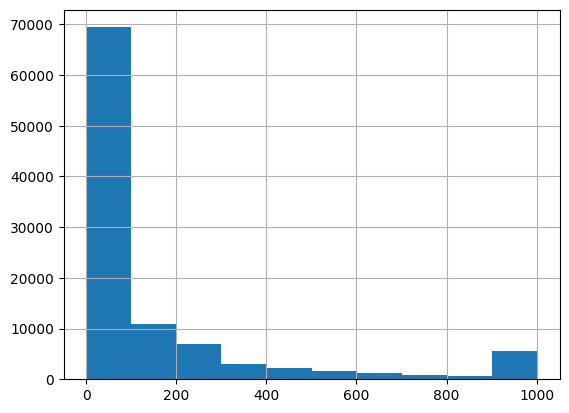

In [ ]:
# Variables of house rules
airbnb.loc[airbnb["house_rules"].isnull() == True, "house_rules"] = ""
airbnb.loc[:,"house_rules_length"] = airbnb["house_rules"].apply(len)
airbnb["house_rules_length"].hist()

### Recoding variables

I recode cancellation policies, instant bookability, room types, and neighborhood data into factor variables.

In [ ]:
# Factor variable
policy = pd.get_dummies(airbnb["cancellation_policy"], "cancellation")
airbnb = airbnb.join(policy)

In [ ]:
# Binary variable
airbnb["instant_bookable_dummy"] = 0
airbnb.loc[airbnb["instant_bookable"]==True, "instant_bookable_dummy"] = 1

In [ ]:
# Factor Variable
roomtypes = pd.get_dummies(airbnb["room type"])
airbnb = airbnb.join(roomtypes)

In [ ]:
neighbourhoods = pd.get_dummies(airbnb["neighbourhood"])
airbnb = airbnb.join(neighbourhoods)

In [ ]:
# Model using all data, use Brooklyn as base case
import statsmodels.api as sm
Y = airbnb["totprice"]
X = airbnb[["Bronx", "Manhattan","Queens","Staten Island", "Construction year", "minimum nights",
            "reviews per month", "availability 365", "review rate number", "house_rules_length",
            "cancellation_moderate","cancellation_strict", "instant_bookable_dummy",
            "Hotel room", "Private room", "Shared room"]] # Use Brooklyn as the base, cancellation flexible as base, home/apt as base
X = X.join(pd.get_dummies(airbnb["neighbourhood"]))
X = sm.add_constant(X)
X = X.drop('Allerton', axis=1) # Allerton is base
model = sm.OLS(Y,X, missing="drop")
results = model.fit()
results.summary()

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(airbnb["long"], airbnb["lat"], c=airbnb["price"], cmap='coolwarm', alpha=0.7, s = .1)
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Price Heatmap')
plt.grid(False)
plt.show()

NameError: name 'airbnb' is not defined

<Figure size 1000x600 with 0 Axes>

## Extracting Name Data Variables

The types of words available in the `NAME` variable would likel

In [ ]:
# Collecting counts of all words used for listings
from collections import Counter
import string

names_counter = Counter()
for words in airbnb["NAME"]:
  words = str(words).lower()
  words = ''.join([char for char in words if char not in string.punctuation])
  for word in str(words).split(' '):
      names_counter[word] += 1

names = list(names_counter.keys())
counts = list(names_counter.values())

text_counts = {"names": names, "counts": counts}
text_df = pd.DataFrame(text_counts)

In [ ]:
# Getting rid of obviously trivial words
bad_names = ["and","AND","by","the",""," ","","UNTITLED","or","For","for","OF", "MY","My","an", "4"]

# Filtering text to high frequency, non-trivial words
freq_lim = 1000 # determines how often words have to be used to be included
text_filter = text_df.loc[text_df['counts'] > freq_lim,]
text_filter = text_filter[~text_filter["names"].isin(bad_names)]
text_filter

,names,counts
0,clean,2283
2,quiet,2514
3,apt,9335
4,home,4059
7,park,6364
...,...,...
567,bushwick,2691
572,away,1086
610,bedstuy,1146
670,minutes,1038


In [ ]:
# Create filtered names from acceptable names
airbnb_text = airbnb[["id","NAME","price"]]
airbnb_text["NAME"] = airbnb_text["NAME"].str.lower()

def filter_words(text):
    return ' '.join([word for word in str(text).split(' ') if word in list(text_filter["names"])])

# Apply the function to the 'text' column
airbnb_text['filtered_text'] = airbnb_text['NAME'].apply(filter_words)

airbnb_text

<ipython-input-16-c8ca9f06552f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_text["NAME"] = airbnb_text["NAME"].str.lower()
<ipython-input-16-c8ca9f06552f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airbnb_text['filtered_text'] = airbnb_text['NAME'].apply(filter_words)


,id,NAME,price,filtered_text
0,1001254,clean & quiet apt home by the park,966,clean quiet apt home park
1,1002102,skylit midtown castle,142,midtown
2,1002403,the village of harlem....new york !,620,village of york
3,1002755,NaN,368,
4,1003689,entire apt: spacious studio/loft by central park,204,entire spacious central park
...,...,...,...,...
102319,6092437,spare room in williamsburg,844,room in williamsburg
102320,6092990,best location near columbia u,837,best location near
102321,6093542,"comfy, bright room in brooklyn",988,bright room in brooklyn
102322,6094094,big studio-one stop from midtown,546,big from midtown


In [ ]:
# Create empty rows
for word in text_filter["names"]:
    airbnb_text[word] = 0

In [ ]:
# Update the columns with 1 if the word is in the text
for idx, row in airbnb_text.iterrows():
  for word in row['filtered_text'].split(' '):
      airbnb_text.at[idx, word] = 1

airbnb_text = airbnb_text.drop("",axis=1)

airbnb_text

,id,NAME,price,filtered_text,clean,quiet,apt,home,park,midtown,...,comfortable,astoria,4,gorgeous,min,bushwick,away,bedstuy,minutes,jfk
0,1001254,clean & quiet apt home by the park,966,clean quiet apt home park,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1002102,skylit midtown castle,142,midtown,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1002403,the village of harlem....new york !,620,village of york,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1002755,NaN,368,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1003689,entire apt: spacious studio/loft by central park,204,entire spacious central park,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102319,6092437,spare room in williamsburg,844,room in williamsburg,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102320,6092990,best location near columbia u,837,best location near,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102321,6093542,"comfy, bright room in brooklyn",988,bright room in brooklyn,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102322,6094094,big studio-one stop from midtown,546,big from midtown,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Make array of values and reduce dimensionality with PCR
text_array = np.array(airbnb_text.drop(["id","NAME","price","filtered_text"],axis=1))

import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(text_array)
reduced = pca.fit_transform(text_array)
reduced_df_pca = pd.DataFrame(data=reduced,columns=["textfeat1","textfeat2","textfeat3"])

In [ ]:
# PLS Regression

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate

# Running PLS
pls_model = PLSRegression(n_components = 2)
pls_model.fit(text_array, airbnb["price"])

comp = pls_model.transform(text_array)
reduced_df_pls = pd.DataFrame(data=comp,columns=["textfeat1","textfeat2"])

## Testing Models - OLS and Lasso

In [ ]:
from sklearn.model_selection import train_test_split

df = airbnb.join(reduced_df_pls)
df = df[["price","textfeat1","textfeat2","Bronx", "Manhattan","Queens","Staten Island"]]
df = df.dropna()

# Splitting test and training
split_data = train_test_split(df, random_state = 1, test_size = .2)
training = split_data[0]
test = split_data[1]

# Splitting into x and y
y_train = np.float64(training["price"])
X_train = np.float64(training.drop("price",axis=1))

y_test = np.float64(test["price"])
X_test = np.float64(test.drop("price",axis=1))

print("Training obs: {}".format(training.shape[0]))
print("Test obs: {}".format(test.shape[0]))

Training obs: 81859
Test obs: 20465


In [ ]:
# Model using all data, use Brooklyn as base case
import statsmodels.api as sm
X = sm.add_constant(X_test)
model = sm.OLS(y_test,X, missing="drop")
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.829
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           1.22e-09
Time:                        00:55:55   Log-Likelihood:            -1.4775e+05
No. Observations:               20465   AIC:                         2.955e+05
Df Residuals:                   20458   BIC:                         2.956e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        623.1713      3.693    168.750      0.000     615.933     630.410
x1           -14.5678      2.255     -6.461      0.000     -18.987     -10.149
x2             4.4361      2.008      2.210      0.027       0.501       8.371
x3            10.9013     14.668      0.743      0.457     -17.849      39.651
x4             2.1610      5.262      0.411      0.681      -8.154      12.476
x5            17.0609      7.489      2.278      0.023       2.381      31.741
x6           -10.5381     25.050     -0.421      0.674     -59.639      38.563
==============================================================================
Omnibus:                    16239.398   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1204.733
Skew:                          -0.004   Prob(JB):                    2.49e-262
Kurtosis:                       1.811   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get Test MSE
y_pred = model.predict(X_test)
print("Test MSE:", np.mean((y_test - y_pred)**2))

Test MSE: 109559.43549001795


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Running Lasso
lasso_model = Lasso(alpha=.5)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
premium = y_test - y_pred
print("Test MSE:", np.mean((premium)**2))

Test MSE: 109554.27373091028


In [ ]:
# PLS Regression

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate

# Running PLS
pls_model = PLSRegression(n_components = 2)
pls_model.fit(X_train, y_train)
y_pred = pls_model.predict(X_test)
print("Test MSE:", np.mean((y_test - y_pred)**2))

Test MSE: 109577.83597975953


In [8]:
!git config --global user.email '$joshua.jacobs@emory.edu'
!git config --global user.name '$joshuajacobs2020'

In [13]:
from getpass import getpass
uname="joshuajacobs2020"
password = getpass('Password:')
!git clone https://github.com/joshuajacobs2020/AirbnbPricePrediction
%cd AirbnbPricePrediction

Password:··········
fatal: destination path 'AirbnbPricePrediction' already exists and is not an empty directory.
/content/AirbnbPricePrediction


In [16]:
!git add "Airbnb Data Cleaning.ipynb"
!git commit -m 'commit message'  # commit in Colab
!git push origin master

fatal: pathspec 'Airbnb Data Cleaning.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
error: src refspec master does not match any
error: failed to push some refs to 'https://github.com/joshuajacobs2020/AirbnbPricePrediction'
